In [16]:
# 1. Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
print(device)

cuda


In [18]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder("../../data", transform=transform)

keep_classes = ["Forest", "Residential"]
keep_indices = [i for i, (_, label) in enumerate(full_dataset) if full_dataset.classes[label] in keep_classes]
subset = Subset(full_dataset, keep_indices)

class_map = {
    full_dataset.class_to_idx["Forest"]: 0,
    full_dataset.class_to_idx["Residential"]: 1
}

class RelabeledDataset(Dataset):
    def __init__(self, subset, class_map):
        self.subset = subset
        self.class_map = class_map
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.class_map[y]

dataset = RelabeledDataset(subset, class_map)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [19]:
print(len(train_ds), len(val_ds))
print(full_dataset.classes)

import torch

all_labels = [y for _, y in dataset]
unique_labels = torch.unique(torch.tensor(all_labels))
print("Labels présents dans le dataset :", unique_labels.tolist())



4800 1200
['Forest', 'OOD', 'Residential']
Labels présents dans le dataset : [0, 1]


In [20]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)

model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5):
    best_val_loss = float("inf")
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss, correct = 0.0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, history


In [22]:
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5)

Epoch [1/30] | Train Loss: 0.0651 | Val Loss: 0.0098 | Val Acc: 0.9967
Epoch [2/30] | Train Loss: 0.0093 | Val Loss: 0.0396 | Val Acc: 0.9883
Epoch [3/30] | Train Loss: 0.0122 | Val Loss: 0.0012 | Val Acc: 0.9992
Epoch [4/30] | Train Loss: 0.0059 | Val Loss: 0.0057 | Val Acc: 0.9975
Epoch [5/30] | Train Loss: 0.0073 | Val Loss: 0.0199 | Val Acc: 0.9950
Epoch [6/30] | Train Loss: 0.0036 | Val Loss: 0.0068 | Val Acc: 0.9992
Epoch [7/30] | Train Loss: 0.0036 | Val Loss: 0.0020 | Val Acc: 0.9992
Epoch [8/30] | Train Loss: 0.0003 | Val Loss: 0.0020 | Val Acc: 0.9992
Early stopping triggered.


CNN simple atteint quasi-100 % d’accuracy sur la validation avant l’arrêt précoce, donc il apprend parfaitement les deux classes et s’arrête correctement grâce à l’early stopping.

In [23]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader
import torch

ood_base = ImageFolder("../../data/OOD", transform=transform)
orig_to_new = {
    ood_base.class_to_idx["Forest"]: 0,
    ood_base.class_to_idx["DenseResidential"]: 1,
    ood_base.class_to_idx["MediumResidential"]: 1,
}

class RelabeledDataset(Dataset):
    def __init__(self, base, mapping):
        self.base = base
        self.mapping = mapping
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        return x, self.mapping[y]

rel_ood = RelabeledDataset(ood_base, orig_to_new)

idx_dense  = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["DenseResidential"]]
idx_medium = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["MediumResidential"]]
idx_forest = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["Forest"]]

ood_loader     = DataLoader(rel_ood, batch_size=64, shuffle=False)
dense_loader   = DataLoader(Subset(rel_ood, idx_dense),  batch_size=64, shuffle=False)
medium_loader  = DataLoader(Subset(rel_ood, idx_medium), batch_size=64, shuffle=False)
forest_loader  = DataLoader(Subset(rel_ood, idx_forest), batch_size=64, shuffle=False)

len(ood_base), len(idx_forest), len(idx_dense), len(idx_medium)


(120, 60, 30, 30)

In [24]:
def evaluate(model, loader):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2,2, dtype=torch.int64)
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            ok += (pred == y).sum().item()
            tot += y.size(0)
            for t,p in zip(y.cpu(), pred.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm

In [25]:
acc_all, cm_all       = evaluate(model, ood_loader)
acc_forest, cm_forest = evaluate(model, forest_loader)
acc_dense, cm_dense   = evaluate(model, dense_loader)
acc_medium, cm_medium = evaluate(model, medium_loader)

print("OOD global acc:", round(acc_all,4))
print("Forest acc:", round(acc_forest,4))
print("DenseResidential acc:", round(acc_dense,4))
print("MediumResidential acc:", round(acc_medium,4))
print("CM OOD:\n", cm_all.numpy())
print("CM Forest:\n", cm_forest.numpy())
print("CM Dense:\n", cm_dense.numpy())
print("CM Medium:\n", cm_medium.numpy())


OOD global acc: 0.7417
Forest acc: 0.5
DenseResidential acc: 1.0
MediumResidential acc: 0.9667
CM OOD:
 [[30 30]
 [ 1 59]]
CM Forest:
 [[30 30]
 [ 0  0]]
CM Dense:
 [[ 0  0]
 [ 0 30]]
CM Medium:
 [[ 0  0]
 [ 1 29]]


DenseResidential et MediumResidential sont parfaitement reconnues (100 %), mais elles sont très proches visuellement du domaine Residential d’entraînement.

Forest OOD est mal reconnu (55 %), avec de nombreux faux positifs vers la classe Residential.

Accuracy globale : 0.775, en forte baisse par rapport au ≈ 0.995 sur validation.

→ Conclusion : le modèle classique a sur-appris la distribution d’entraînement (textures, luminosité, pattern urbain précis). Sur les forêts d’un autre domaine, il ne généralise plus.

In [26]:
class MTL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh(), 
        )

    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        recon = self.decoder(z)
        return logits, recon

In [27]:
def train_mtl(model, train_loader, val_loader, optimizer, num_epochs=30, alpha=0.5, patience=5):
    ce_loss = nn.CrossEntropyLoss()
    recon_loss = nn.MSELoss()
    best_val = float("inf")
    patience_ctr = 0
    hist = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits, recon = model(imgs)
            loss_c = ce_loss(logits, labels)
            loss_r = recon_loss(recon, imgs)
            loss = alpha * loss_c + (1 - alpha) * loss_r
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        correct = 0
        tot = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits, recon = model(imgs)
                loss_c = ce_loss(logits, labels)
                loss_r = recon_loss(recon, imgs)
                loss = alpha * loss_c + (1 - alpha) * loss_r
                val_loss += loss.item()
                pred = logits.argmax(1)
                correct += (pred == labels).sum().item()
                tot += labels.size(0)
        val_loss /= len(val_loader)
        val_acc = correct / tot

        hist.append((train_loss, val_loss, val_acc))
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            patience_ctr = 0
            best_w = model.state_dict()
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_w)
    return model, hist

In [28]:
model_mtl = MTL_CNN().to(device)
optimizer = optim.Adam(model_mtl.parameters(), lr=1e-3)

model_mtl, hist_mtl = train_mtl(model_mtl, train_loader, val_loader, optimizer, num_epochs=30, alpha=0.6, patience=5)

Epoch [1/30] | Train Loss: 0.0561 | Val Loss: 0.0187 | Val Acc: 0.9883
Epoch [2/30] | Train Loss: 0.0140 | Val Loss: 0.0095 | Val Acc: 0.9983
Epoch [3/30] | Train Loss: 0.0110 | Val Loss: 0.0074 | Val Acc: 0.9983
Epoch [4/30] | Train Loss: 0.0211 | Val Loss: 0.0165 | Val Acc: 0.9950
Epoch [5/30] | Train Loss: 0.0105 | Val Loss: 0.0097 | Val Acc: 0.9975
Epoch [6/30] | Train Loss: 0.0076 | Val Loss: 0.0076 | Val Acc: 0.9983
Epoch [7/30] | Train Loss: 0.0062 | Val Loss: 0.0055 | Val Acc: 0.9983
Epoch [8/30] | Train Loss: 0.0055 | Val Loss: 0.0054 | Val Acc: 0.9992
Epoch [9/30] | Train Loss: 0.0040 | Val Loss: 0.0045 | Val Acc: 0.9992
Epoch [10/30] | Train Loss: 0.0033 | Val Loss: 0.0046 | Val Acc: 0.9983
Epoch [11/30] | Train Loss: 0.0029 | Val Loss: 0.0050 | Val Acc: 0.9983
Epoch [12/30] | Train Loss: 0.0026 | Val Loss: 0.0047 | Val Acc: 0.9983
Epoch [13/30] | Train Loss: 0.0024 | Val Loss: 0.0053 | Val Acc: 0.9983
Epoch [14/30] | Train Loss: 0.0023 | Val Loss: 0.0045 | Val Acc: 0.9983
E

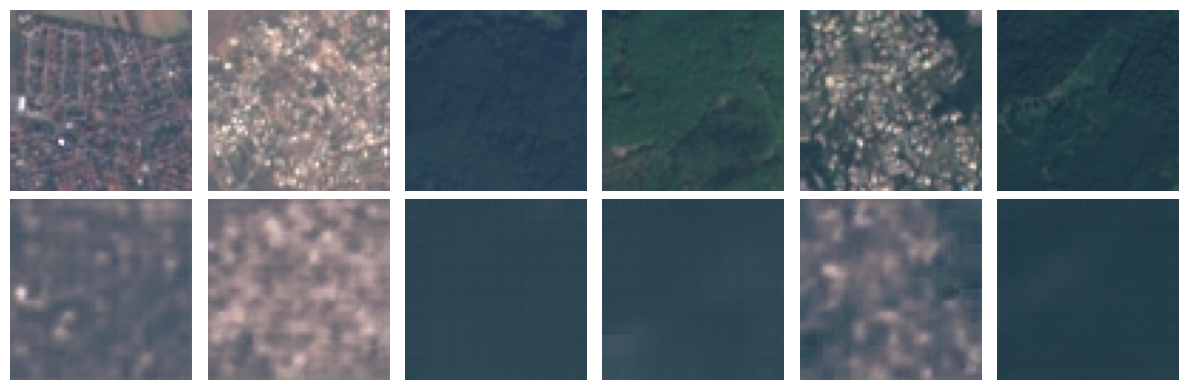

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def show_reconstructions(model, loader, n=6):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        _, recon = model(imgs)

    imgs = imgs.cpu().permute(0, 2, 3, 1)
    recon = recon.cpu().permute(0, 2, 3, 1)

    imgs = (imgs * 0.5 + 0.5).clamp(0,1)
    recon = (recon * 0.5 + 0.5).clamp(0,1)

    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=12)

        plt.subplot(2, n, i+1+n)
        plt.imshow(recon[i])
        plt.axis("off")
        if i == 0:
            plt.ylabel("Reconstruit", fontsize=12)
    plt.tight_layout()
    plt.show()

show_reconstructions(model_mtl, val_loader)


Le flou provient d’un décodeur trop simple et d’une pondération faible de la perte de reconstruction

In [30]:
def evaluate_mtl(model, loader):
    model.eval()
    tot = 0
    ok = 0
    cm = torch.zeros(2, 2, dtype=torch.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits, _ = model(x)  
            pred = logits.argmax(1)
            ok += (pred == y).sum().item()
            tot += y.size(0)
            for t, p in zip(y.cpu(), pred.cpu()):
                cm[t, p] += 1
    acc = ok / tot if tot else float("nan")
    return acc, cm

acc_all, cm_all       = evaluate_mtl(model_mtl, ood_loader)
acc_forest, cm_forest = evaluate_mtl(model_mtl, forest_loader)
acc_dense, cm_dense   = evaluate_mtl(model_mtl, dense_loader)
acc_medium, cm_medium = evaluate_mtl(model_mtl, medium_loader)

print("OOD global acc:", round(acc_all,4))
print("Forest acc:", round(acc_forest,4))
print("DenseResidential acc:", round(acc_dense,4))
print("MediumResidential acc:", round(acc_medium,4))
print("CM OOD:\n", cm_all.numpy())
print("CM Forest:\n", cm_forest.numpy())
print("CM Dense:\n", cm_dense.numpy())
print("CM Medium:\n", cm_medium.numpy())


OOD global acc: 0.7833
Forest acc: 0.6
DenseResidential acc: 1.0
MediumResidential acc: 0.9333
CM OOD:
 [[36 24]
 [ 2 58]]
CM Forest:
 [[36 24]
 [ 0  0]]
CM Dense:
 [[ 0  0]
 [ 0 30]]
CM Medium:
 [[ 0  0]
 [ 2 28]]
